<a href="https://colab.research.google.com/github/AndreYang333/ExplainableAI/blob/main/%E2%80%9Cadversarialpatch_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/stanford-cs231n/cs231n.github.io.git

# Download the Tiny ImageNet dataset
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-imagenet-200/val/images/val

In [3]:
# Install required libraies
!pip install torch torchvision numpy matplotlib


In [4]:
# Import required modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from tqdm import tqdm
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split

In [5]:
# Load the pretrained ResNet34 model
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()  # Set model to evaluation mode


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 53.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:

from torch.utils.data import Subset

# Define image transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    #transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),  # Tiny ImageNet normalization values
])

# Load full train and validation datasets
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

# Create a subset for training and validation (10% of the dataset)
train_size = len(train_dataset)
val_size = len(val_dataset)

# Indices for 10% of the data
train_indices = np.random.choice(train_size, size=train_size // 50, replace=False)
val_indices = np.random.choice(val_size, size=val_size // 50, replace=False)

# Subset the datasets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Create DataLoaders for the subset
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = DataLoader(val_subset, batch_size=64, shuffle=False)

# Check the new dataset sizes
print(f"Subset Training Dataset Size: {len(train_subset)}")
print(f"Subset Validation Dataset Size: {len(val_subset)}")


Subset Training Dataset Size: 2000
Subset Validation Dataset Size: 200


In [7]:
with open('data/imagenet_classes.txt') as f:
    class_names = [line.strip() for line in f.readlines()]

# Select a target class
target_class_name = 'goldfish'
target_class_index = class_names.index(target_class_name)
print(f"Target Class Index for '{target_class_name}': {target_class_index}")

Target Class Index for 'goldfish': 1


In [8]:
# Apply patch to the image at a random location with random rotation
def apply_patch(image, patch):
    """
    Applies the adversarial patch to the image at a random location with random rotation.
    """
    image = image.clone()
    _, img_height, img_width = image.shape
    patch_height, patch_width = patch.shape[1], patch.shape[2]

    # Random rotation angle between 0 and 360 degrees
    #rotation_angle = np.random.uniform(0, 360)

    # Rotate the image and patch randomly
    # rotated_image = F.rotate(image, rotation_angle)
    # rotated_patch = F.rotate(patch, rotation_angle)

    # Ensure patch fits within the image after rotation
    # patch_height, patch_width = rotated_patch.shape[1], rotated_patch.shape[2]

    # Random position for the patch
    x_pos = np.random.randint(0, img_width - patch_width)
    y_pos = np.random.randint(0, img_height - patch_height)

    # Apply the patch to the rotated image
    image[:, y_pos:y_pos+patch_height, x_pos:x_pos+patch_width] = patch

    return image

Patch size: torch.Size([3, 112, 112])


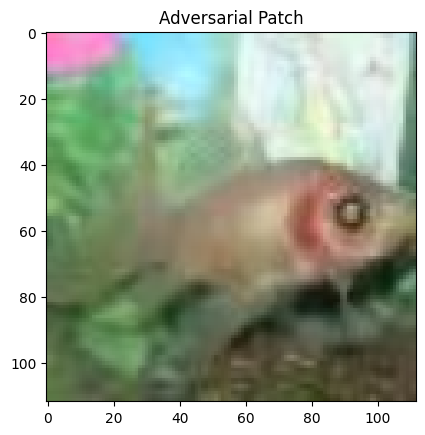

In [22]:
image_path = 'data/n01443537_0.JPEG'  # 替换为你的图片路径
image = Image.open(image_path)

# 定义图片的转换，包括调整大小和转化为张量
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # 更大的尺寸
    transforms.ToTensor(),
])
# 应用转换，得到的张量形状为 (3, 112, 112)
adversarial_patch = transform(image)
adversarial_patch.data.clamp_(0, 1)
# 检查 patch 的尺寸
print(f"Patch size: {patch.size()}")  # 应该输出 torch.Size([3, 56, 56])

# 显示这个 patch
plt.imshow(adversarial_patch.permute(1, 2, 0))  # Permute to (H, W, C) for display
plt.title("Adversarial Patch")
plt.show()

#patch_size = (3, 112, 112)

# Initialize patch
#adversarial_patch = torch.rand(*patch_size, requires_grad=True)

# Ensure value is in [0,1]
#adversarial_patch.data.clamp_(0, 1)

# print the shape of patch
#print(f"Adversarial patch shape: {adversarial_patch.shape}")

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
adversarial_patch = adversarial_patch.to(device)
# Use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer with learning rate and weight decay
optimizer = optim.Adam([adversarial_patch], lr=0.01)




In [ ]:
# Initialize lists to store training, test loss values, and parameters
train_loss_values = []
val_loss_values = []
saved_params_withnoclamp = []  # List to store the parameters of the model and adversarial patch

num_epochs = 4
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    batch_count = 0

    # Training phase
    model.train()  # Set the model to training mode
    with tqdm(trainloader, unit="batch") as tepoch:
        for images, _ in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images = images.clone().to(device)

            # Apply the patch to each image in the batch
            patched_images = torch.stack([apply_patch(img, adversarial_patch) for img in images]).to(device)

            # Forward pass
            outputs = model(patched_images)

            # Create target labels (all as the target class)
            target_labels = torch.full((images.size(0),), target_class_index, dtype=torch.long).to(device)

            # Compute loss
            loss = criterion(outputs, target_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Clamp patch values to [0,1]
            # adversarial_patch.data.clamp_(0, 1)

            # Accumulate loss for the current batch
            epoch_loss += loss.item()
            batch_count += 1

            # Display the loss for the current batch
            tepoch.set_postfix(loss=loss.item())

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / batch_count
    train_loss_values.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}")

    # Save model parameters and adversarial_patch for each epoch
    model_params = {name: param.detach().clone() for name, param in model.named_parameters()}  # Save model parameters
    saved_params_withnoclamp.append({
        'epoch': epoch + 1,
        'model_params': model_params,
        'adversarial_patch': adversarial_patch.detach().clone()
    })

    # Evaluation phase (Test loss calculation)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_batch_count = 0

    # Turn off gradient computation during evaluation
    with torch.no_grad():
        with tqdm(valloader, unit="batch") as tepoch:
            for images, _ in tepoch:
                tepoch.set_description(f"Evaluating Validation Set (Epoch {epoch+1})")

                images = images.clone().to(device)

                # Apply the patch to each test image in the batch
                patched_images = torch.stack([apply_patch(img, adversarial_patch) for img in images]).to(device)

                # Forward pass
                outputs = model(patched_images)

                # Create target labels (all as the target class)
                target_labels = torch.full((images.size(0),), target_class_index, dtype=torch.long).to(device)

                # Compute test loss
                loss = criterion(outputs, target_labels)

                # Accumulate the test loss
                val_loss += loss.item()
                val_batch_count += 1

                tepoch.set_postfix(val_loss=loss.item())

    # Calculate average test loss for the epoch
    avg_val_loss = val_loss / val_batch_count
    val_loss_values.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Test Loss: {avg_val_loss:.4f}")

# Plot training and test loss over epochs
plt.plot(train_loss_values, label='Training Loss', marker='o')
plt.plot(val_loss_values, label='Validation Loss', marker='x')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Epoch 1/4:   0%|          | 0/32 [00:00<?, ?batch/s]

In [69]:


# Evaluate the patch
model.eval()
success = 0
total = 0

for images, labels in valloader:
    patched_images = [apply_patch(img, adversarial_patch).unsqueeze(0) for img in images]
    patched_images = torch.cat(patched_images)

    # Forward pass
    outputs = model(patched_images)
    _, predicted = outputs.max(1)

    total += predicted.size(0)
    success += (predicted == target_class_index).sum().item()


print(f"Attack Success Rate: {100 * success / total:.2f}%")


Attack Success Rate: 1.80%


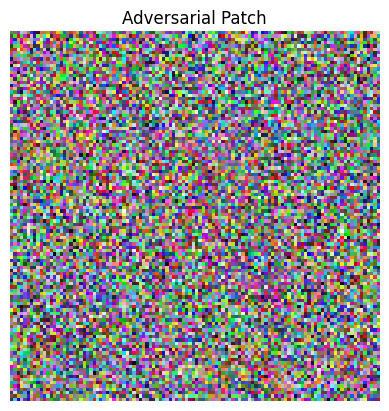

In [70]:
# Convert patch tensor to PIL Image for visualization
def tensor_to_pil(tensor):
    tensor = tensor.detach().cpu()
    tensor = transforms.ToPILImage()(tensor)
    return tensor

patch_image = tensor_to_pil(adversarial_patch)
plt.imshow(patch_image)
plt.title("Adversarial Patch")
plt.axis('off')
plt.show()


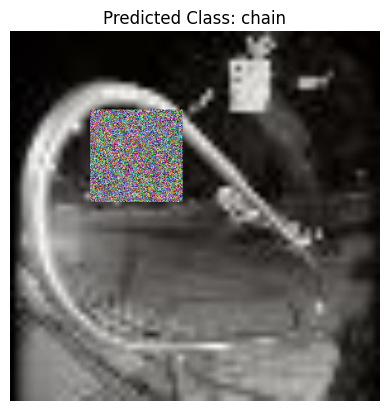

In [73]:
# Display a sample patched image
sample_image, _ = next(iter(valloader))
patched_sample = apply_patch(sample_image[0], adversarial_patch)
patched_sample = patched_sample.unsqueeze(0)

# Get model prediction
outputs = model(patched_sample)
#outputs = model(sample_image[0].unsqueeze(0))
_, predicted = outputs.max(1)
predicted_class = class_names[predicted.item()]

# Display the image
patched_sample_image = tensor_to_pil(patched_sample[0])
#patched_sample_image = tensor_to_pil(sample_image[0])
plt.imshow(patched_sample_image)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()
